In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os

In [229]:
import numpy as np
import pandas as pd

def calculate_angle(p1, p2, p3):
    """
    Calculate the angle at p2 formed by the line segments p1-p2 and p3-p2.
    Arguments:
    - p1, p2, p3: Arrays or lists containing the coordinates [x, y].
    Returns:
    - Angle in degrees.
    """
    v1 = np.array(p1) - np.array(p2)
    v2 = np.array(p3) - np.array(p2)
    dot_product = np.dot(v1, v2)
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    if magnitude_v1 == 0 or magnitude_v2 == 0:
        return None
    angle_radians = np.arccos(np.clip(dot_product / (magnitude_v1 * magnitude_v2), -1.0, 1.0))
    return np.degrees(angle_radians)

# Input and output CSV files
input_file = "merged_output.csv"
output_file = "enhanced_features.csv"

columns = {
    "LEFT_HIP": ["LEFT_HIP_x", "LEFT_HIP_y"],
    "LEFT_KNEE": ["LEFT_KNEE_x", "LEFT_KNEE_y"],
    "LEFT_ANKLE": ["LEFT_ANKLE_x", "LEFT_ANKLE_y"],
    "RIGHT_HIP": ["RIGHT_HIP_x", "RIGHT_HIP_y"],
    "RIGHT_KNEE": ["RIGHT_KNEE_x", "RIGHT_KNEE_y"],
    "RIGHT_ANKLE": ["RIGHT_ANKLE_x", "RIGHT_ANKLE_y"],
    "LEFT_SHOULDER": ["LEFT_SHOULDER_x", "LEFT_SHOULDER_y"],
    "RIGHT_SHOULDER": ["RIGHT_SHOULDER_x", "RIGHT_SHOULDER_y"]
}

# Load dataset
df = pd.read_csv(input_file)

# Center of Mass (COM)
df['COM_x'] = (df['LEFT_HIP_x'] + df['RIGHT_HIP_x']) / 2
df['COM_y'] = (df['LEFT_HIP_y'] + df['RIGHT_HIP_y']) / 2

# Deltas for COM
df['delta_COM_x'] = df['COM_x'].diff()
df['delta_COM_y'] = df['COM_y'].diff()

# Key distances
df['shoulder_distance'] = np.sqrt(
    (df['LEFT_SHOULDER_x'] - df['RIGHT_SHOULDER_x'])**2 +
    (df['LEFT_SHOULDER_y'] - df['RIGHT_SHOULDER_y'])**2
)
df['hip_distance'] = np.sqrt(
    (df['LEFT_HIP_x'] - df['RIGHT_HIP_x'])**2 +
    (df['LEFT_HIP_y'] - df['RIGHT_HIP_y'])**2
)
df['ankle_distance'] = np.sqrt(
    (df['LEFT_ANKLE_x'] - df['RIGHT_ANKLE_x'])**2 +
    (df['LEFT_ANKLE_y'] - df['RIGHT_ANKLE_y'])**2
)

# Joint angles
df['LEFT_KNEE_ANGLE'] = df.apply(
    lambda row: calculate_angle(
        [row[columns["LEFT_HIP"][0]], row[columns["LEFT_HIP"][1]]],
        [row[columns["LEFT_KNEE"][0]], row[columns["LEFT_KNEE"][1]]],
        [row[columns["LEFT_ANKLE"][0]], row[columns["LEFT_ANKLE"][1]]]
    ), axis=1
)
df['RIGHT_KNEE_ANGLE'] = df.apply(
    lambda row: calculate_angle(
        [row[columns["RIGHT_HIP"][0]], row[columns["RIGHT_HIP"][1]]],
        [row[columns["RIGHT_KNEE"][0]], row[columns["RIGHT_KNEE"][1]]],
        [row[columns["RIGHT_ANKLE"][0]], row[columns["RIGHT_ANKLE"][1]]]
    ), axis=1
)

# Velocities and accelerations
frame_time = 0.033  # Time per frame (30 FPS)

# Calculate velocities
for feature in ['hip_distance', 'ankle_distance', 'COM_x', 'COM_y']:
    df[f'{feature}_velocity'] = df[feature].diff() / frame_time
    df[f'{feature}_acceleration'] = df[f'{feature}_velocity'].diff() / frame_time

# Angle deltas
df['delta_left_knee_angle'] = df['LEFT_KNEE_ANGLE'].diff()
df['delta_right_knee_angle'] = df['RIGHT_KNEE_ANGLE'].diff()

# Fill NaN values
df.fillna(0, inplace=True)

# Save enhanced dataset
df.to_csv(output_file, index=False)


In [230]:
filtered_features = [
    'LEFT_KNEE_ANGLE', 'RIGHT_KNEE_ANGLE',
    'delta_left_knee_angle', 'delta_right_knee_angle',
    'shoulder_distance', 'hip_distance', 'ankle_distance',
    'hip_distance_velocity', 'ankle_distance_velocity',
    'hip_distance_acceleration', 'ankle_distance_acceleration',
    'COM_x_velocity', 'COM_y_velocity', 'COM_x_acceleration', 'COM_y_acceleration',
    'annotation'
]

filtered_data = df[filtered_features]
filtered_data.to_csv("filtered_movement_data.csv", index=False)

In [233]:
filtered_data[filtered_data['annotation'] == 'approach']

,LEFT_KNEE_ANGLE,RIGHT_KNEE_ANGLE,delta_left_knee_angle,delta_right_knee_angle,shoulder_distance,hip_distance,ankle_distance,hip_distance_velocity,ankle_distance_velocity,hip_distance_acceleration,ankle_distance_acceleration,COM_x_velocity,COM_y_velocity,COM_x_acceleration,COM_y_acceleration,annotation
9,171.528120,175.626763,-2.384351,0.729919,0.118848,0.068727,0.082396,-0.001075,-0.047250,-0.611560,-0.663338,-0.026571,-0.006657,0.106169,-0.445557,approach
10,169.684237,176.265301,-1.843883,0.638538,0.119109,0.068433,0.080844,-0.008923,-0.047034,-0.237821,0.006537,-0.027289,0.000292,-0.021729,0.210573,approach
11,168.595838,175.562138,-1.088399,-0.703163,0.119589,0.068240,0.078921,-0.005832,-0.058253,0.093675,-0.339953,0.004082,0.007531,0.950637,0.219371,approach
12,168.098385,174.561027,-0.497453,-1.001111,0.119994,0.068226,0.077467,-0.000433,-0.044058,0.163620,0.430124,0.003100,0.029262,-0.029761,0.658511,approach
13,168.526094,174.075165,0.427709,-0.485862,0.120395,0.068311,0.075737,0.002589,-0.052429,0.091548,-0.253657,0.001345,0.009315,-0.053201,-0.604462,approach
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4219,179.246729,178.569472,0.024278,0.528535,0.095575,0.055597,0.051464,0.016462,0.039299,-0.049988,0.064074,-0.009397,0.007768,-0.323912,1.222032,approach
4220,179.189492,178.681255,-0.057237,0.111782,0.096531,0.055979,0.051941,0.011581,0.014462,-0.147909,-0.752662,-0.005236,-0.006633,0.126106,-0.436389,approach
4221,179.213531,178.366384,0.024039,-0.314871,0.097719,0.056242,0.052308,0.007969,0.011105,-0.109456,-0.101713,-0.004490,-0.020855,0.022605,-0.430971,approach
4222,179.239472,178.404150,0.025941,0.037766,0.098476,0.056534,0.052467,0.008847,0.004841,0.026632,-0.189829,-0.005510,-0.018741,-0.030924,0.064065,approach


In [231]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle

data = pd.read_csv("filtered_movement_data.csv")

X = data.drop('annotation', axis=1)
y = data['annotation']

# Map annotations to numeric labels
label_map = {
    'Still': 0, 'approach': 1, 'back': 2, 'jump': 3, 'turn_left': 4, 
    'walk_left': 5, 'turn_right': 6, 'walk_right': 7, 
    'sit': 8, 'stand': 9
}
y = y.map(label_map)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost classifier
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Save the model
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(model, f)

c:\Users\sjbs2\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:31:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 83.20%


In [205]:
movement_data = pd.read_csv(output_file)

relevant_columns = [
    'LEFT_KNEE_ANGLE', 'RIGHT_KNEE_ANGLE',
    'shoulder_distance', 'hip_distance',
    'hip_distance_velocity', 'ankle_distance_velocity',
    'delta_left_knee_angle', 'delta_right_knee_angle',
]

# Adding annotation column
relevant_columns.append('annotation')

# Filtering the dataset
filtered_data = movement_data[relevant_columns]

filtered_data.to_csv("filtered_movement_data.csv", index=False)


In [228]:
filtered_data['annotation'].unique()

array(['Still', 'approach', 'back', 'jump', 'turn_left', 'walk_left',
       'turn_right', 'walk_right', 'sit', 'stand'], dtype=object)

In [227]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle

data = pd.read_csv("filtered_movement_data.csv")

X = data.drop('annotation', axis=1)
y = data['annotation']

label_map = {
    'Still': 0, 'approach': 1, 'back': 2, 'jump': 3, 'turn_left': 4, 
    'walk_left': 5, 'turn_right': 6, 'walk_right': 7, 
    'sit': 8, 'stand': 9
}
y = y.map(label_map)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(model, f)


c:\Users\sjbs2\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:21:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 76.35%


In [199]:

# Seleccionar las columnas relevantes
columnas_relevantes = [
    'LEFT_KNEE_ANGLE', 'RIGHT_KNEE_ANGLE',
    'shoulder_distance', 'hip_distance',
    #'ankle_distance',
    #'KNEE_HIP_DISTANCE_LEFT', 'KNEE_HIP_DISTANCE_RIGHT',
]

columnas_relevantes.append('annotation')

# Filtrar el dataframe original para conservar solo las columnas relevantes
df_relevantes = movement_data[columnas_relevantes]

# Seleccionar solo columnas numéricas (excluyendo 'frame' o columnas no numéricas)
columnas_numericas = df_relevantes.select_dtypes(include=['number']).columns

# Excluir las columnas que no queremos que sean delta (ángulos y nose_speed)
columnas_a_excluir = ['LEFT_KNEE_ANGLE', 'RIGHT_KNEE_ANGLE', 'annotation']

# Filtrar las columnas numéricas que no sean ángulos ni nose_speed
columnas_a_incluir = [col for col in columnas_numericas if col not in columnas_a_excluir]

# Calcular deltas solo para las columnas seleccionadas (sin ángulos ni nose_speed)
deltas = df_relevantes[columnas_a_incluir].diff().dropna()

# Reincorporar las columnas no numéricas (como 'annotation', 'LEFT_KNEE_ANGLE', 'RIGHT_KNEE_ANGLE' y 'nose_speed')
for col in ['LEFT_KNEE_ANGLE', 'RIGHT_KNEE_ANGLE']:
    deltas[col] = df_relevantes[col][1:].values

# También reincorporar la columna 'annotation'
deltas['annotation'] = df_relevantes['annotation'][1:].values

# Imprimir el nuevo dataframe con los deltas
deltas[deltas['annotation'] == 'walk_left'].head(50)



,shoulder_distance,hip_distance,LEFT_KNEE_ANGLE,RIGHT_KNEE_ANGLE,annotation
1146,0.001591,0.000178,172.129591,163.104455,walk_left
1147,0.001956,0.003952,170.693143,163.267556,walk_left
1148,0.001723,0.003516,170.147575,164.457936,walk_left
1149,-0.000725,0.004988,170.447566,166.475557,walk_left
1150,0.001725,0.002696,170.223849,169.517664,walk_left
1151,0.002049,0.001364,168.907729,168.642228,walk_left
1152,0.004239,-0.002476,166.082145,170.781199,walk_left
1153,-0.001314,-0.000542,163.371070,171.906565,walk_left
1154,0.000130,-0.002147,159.167273,173.192739,walk_left
1155,-0.005704,0.000505,158.397657,175.551057,walk_left


In [200]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle

X = deltas.drop('annotation', axis=1)

y = deltas['annotation']

# Mapeo de etiquetas de texto a números
etiquetas_map = {
    'Still': 0,
    'approach': 1,
    'back': 2,
    'jump': 3,
    'sit': 4,
    'stand': 5,
    'turn_left': 6,
    'turn_right': 7,
    'walk_left': 8,
    'walk_right': 9
}

# Convertir las etiquetas de texto a números
y_numeric = y.map(etiquetas_map)

# Dividir en entrenamiento y prueba (como antes)
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2, random_state=42)

# Crear el modelo XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Entrenar el modelo
model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular la precisión
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
# Guardar el modelo entrenado en un archivo .pkl
with open('modelo_xgboost.pkl', 'wb') as f:
    pickle.dump(model, f)

c:\Users\sjbs2\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 50.26%


In [ ]:
from scipy.signal import butter, filtfilt, savgol_filter

# Crear los coeficientes del filtro Butterworth
b, a = butter(N=3, Wn=0.933333, btype='low')

# Inicializar DataFrames finales para los datos filtrados y suavizados
filtered_dataset = movement_data.copy()
smoothed_dataset = movement_data.copy()

# Obtener los IDs únicos de los videos
video_ids = movement_data["videoid"].unique()

# Procesar cada video
for video_id in video_ids:
    # Filtrar los datos por el ID del video actual
    video_data = movement_data[movement_data["videoid"] == video_id]
    # Identificar columnas numéricas (exceptuando 'frame')
    numeric_columns = video_data.select_dtypes(include=['number']).columns
    columns_to_filter = [col for col in numeric_columns if col != 'frame']
    # Crear copia de los datos originales para aplicar los filtros
    filtered_data = video_data.copy()
    # Aplicar el filtro Butterworth a las columnas seleccionadas
    for column in columns_to_filter:
        filtered_data[column] = filtfilt(b, a, video_data[column])
    # Crear copia para aplicar el filtro Savitzky-Golay
    smoothed_data = filtered_data.copy()
    for column in columns_to_filter:
        smoothed_data[column] = savgol_filter(filtered_data[column], window_length=11, polyorder=3)
    # Reemplazar los datos filtrados y suavizados en los DataFrames finales
    filtered_dataset.loc[video_data.index, columns_to_filter] = filtered_data[columns_to_filter]
    smoothed_dataset.loc[video_data.index, columns_to_filter] = smoothed_data[columns_to_filter]

C:\Users\juans\AppData\Local\Temp\ipykernel_45236\3758283437.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  video_id_data['SHOULDER_DISTANCE_x'] = abs(video_id_data['LEFT_SHOULDER_x'] - video_id_data['RIGHT_SHOULDER_x'])
C:\Users\juans\AppData\Local\Temp\ipykernel_45236\3758283437.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  video_id_data_filtered['SHOULDER_DISTANCE_x'] = abs(video_id_data_filtered['LEFT_SHOULDER_x'] - video_id_data_filtered['RIGHT_SHOULDER_x'])
C:\Users\juans\AppData\Local\Temp

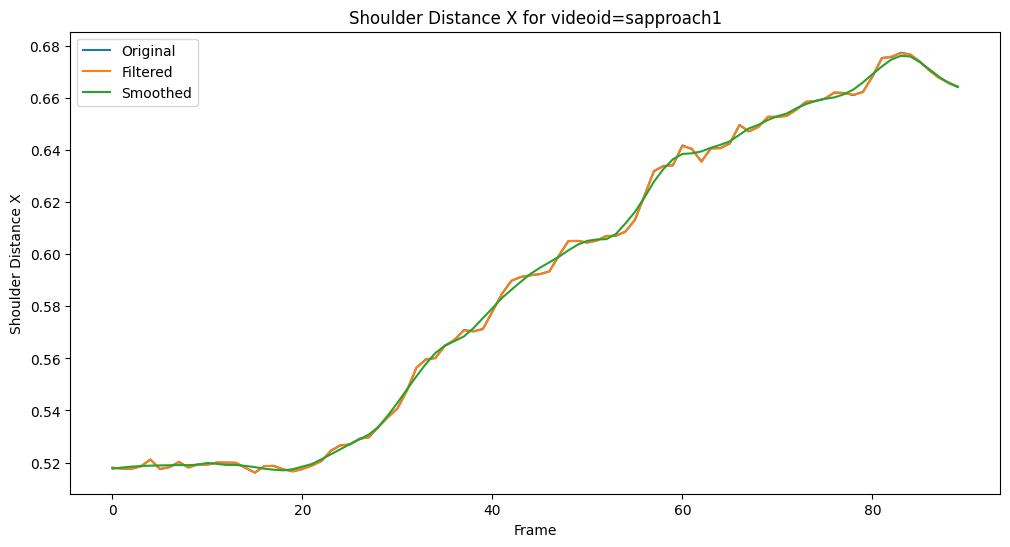

In [31]:
video_id_data = movement_data[movement_data["videoid"] == "sapproach1"]
video_id_data_filtered = filtered_dataset[filtered_dataset["videoid"] == "sapproach1"]
video_id_data_smoothed = smoothed_dataset[smoothed_dataset["videoid"] == "sapproach1"]

video_id_data['SHOULDER_DISTANCE_x'] = abs(video_id_data['LEFT_SHOULDER_x'] - video_id_data['RIGHT_SHOULDER_x'])
video_id_data_filtered['SHOULDER_DISTANCE_x'] = abs(video_id_data_filtered['LEFT_SHOULDER_x'] - video_id_data_filtered['RIGHT_SHOULDER_x'])
video_id_data_smoothed['SHOULDER_DISTANCE_x'] = abs(video_id_data_smoothed['LEFT_SHOULDER_x'] - video_id_data_smoothed['RIGHT_SHOULDER_x']) 

plt.figure(figsize=(12, 6))
plt.plot(video_id_data["frame"], video_id_data["SHOULDER_DISTANCE_x"], label="Original")
plt.plot(video_id_data_filtered["frame"], video_id_data_filtered["SHOULDER_DISTANCE_x"], label="Filtered")
plt.plot(video_id_data_smoothed["frame"], video_id_data_smoothed["SHOULDER_DISTANCE_x"], label="Smoothed")
plt.xlabel('Frame')
plt.ylabel('Shoulder Distance X')
plt.title('Shoulder Distance X for videoid=sapproach1')
plt.legend()
plt.show()


In [32]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

#Model for smoothed
y = smoothed_dataset['annotation']
x = smoothed_dataset.drop(['annotation', 'videoid', 'frame'], axis=1)

labels = y

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
encoded_labels = label_encoder.fit_transform(labels)

# Print the mapping and the encoded labels
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label Mapping:", label_mapping)
print("Encoded Labels:", encoded_labels)

Label Mapping: {'Still': 0, 'approach': 1, 'back': 2, 'jump': 3, 'sit': 4, 'stand': 5, 'turn_left': 6, 'turn_right': 7, 'walk_left': 8, 'walk_right': 9}
Encoded Labels: [0 0 0 ... 5 5 5]


In [33]:
# Normalized
x = movement_data.drop(['annotation', 'videoid', 'frame'], axis=1)  

X_train, X_test, y_train, y_test = train_test_split(x, encoded_labels, test_size=0.2, random_state=42)

model = XGBClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9756258234519104


In [34]:
# Normalized + Filtered 
x = filtered_dataset.drop(['annotation', 'videoid', 'frame'], axis=1)  

X_train, X_test, y_train, y_test = train_test_split(x, encoded_labels, test_size=0.2, random_state=42)

model = XGBClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9808959156785244


In [35]:
# Normalized + Filtered + Smoothed
x = smoothed_dataset.drop(['annotation', 'videoid', 'frame'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, encoded_labels, test_size=0.2, random_state=42)

model = XGBClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9789196310935442


In [36]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Asegúrate de que 'x' y 'encoded_labels' están correctamente definidos
x = smoothed_dataset.drop(['annotation', 'videoid', 'frame'], axis=1)

# Divide los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(x, encoded_labels, test_size=0.2, random_state=42)

# Define el modelo
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define los hiperparámetros para GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Configura GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',  # Métrica de evaluación
    cv=3,  # Número de folds para validación cruzada
    verbose=1,  # Nivel de detalle en la salida
    n_jobs=-1  # Usa todos los núcleos disponibles
)

# Ejecuta GridSearchCV
grid_search.fit(X_train, y_train)

# Obtén los mejores parámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Evalúa el modelo con los mejores parámetros
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calcula la precisión
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy con los mejores hiperparámetros: {accuracy}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits


c:\Users\juans\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 729.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\juans\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\juans\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\juans\AppData\Local\Programs\Python\Python312\Lib\site-package

Mejores hiperparámetros: {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.6}
Accuracy con los mejores hiperparámetros: 0.9776021080368906


In [37]:
import pickle

# Exporta el mejor modelo a un archivo
with open('best_xgb_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Modelo exportado exitosamente como 'best_xgb_model.pkl'")

Modelo exportado exitosamente como 'best_xgb_model.pkl'


In [38]:
#Cargar modelo
"""
import pickle

# Carga el modelo desde el archivo
with open('best_xgb_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Usa el modelo cargado para hacer predicciones
y_pred_new = loaded_model.predict(X_test)
print("Predicciones usando el modelo cargado:", y_pred_new)
"""

'\nimport pickle\n\n# Carga el modelo desde el archivo\nwith open(\'best_xgb_model.pkl\', \'rb\') as file:\n    loaded_model = pickle.load(file)\n\n# Usa el modelo cargado para hacer predicciones\ny_pred_new = loaded_model.predict(X_test)\nprint("Predicciones usando el modelo cargado:", y_pred_new)\n'